## Face Recognition Using Siamese Neural Networks 
#### (Based on paper Koch et al., "Siamese Neural Networks for One-shot Image Recognition")

### Using the Siamese Network Model as described in the paper, we trained the model using LFW images converted to gray-scale, and tested the model on the Olivetti faces dataset
### The weights for the trained model can be downloaded [here](https://drive.google.com/open?id=0By-vPzSwhpQsYnVfcjFRMnpYdms)

### First, we define a class for loading batches and testing tasks to a siamese net
#### (Modified from code [here](https://github.com/sorenbouma/keras-oneshot))

In [1]:
import numpy as np


class DataLoader(object):
    """Object for loading batches and testing tasks to a siamese net

    Args:
        train_data, val_data (list of numpy 3d arrays):
            training and validation data, 
            where data[i] stores numpy 3d array of size 
            number of images x image_size x image_size
        img_size (int): desired image size of loaded data
        olivetti_data (numpy 4d array of size 40 x 10 x image_size x image_size)

    Attributes:
        num_people_train (int): number of different people in training set.
        num_people_val (int): number of different people in validation set.
        img_size (int): size of images

    """

    def __init__(self, train_data, val_data, img_size, olivetti_data):
        self.train_data = train_data
        self.val_data = val_data
        self.olivetti_data = olivetti_data
        
        self.num_people_train = len(train_data)
        self.num_people_val = len(val_data)
        self.img_size = img_size

    def get_training_batch(self, batch_size):
        """Returns training data of size batch_size, 
            where half of instances are same class, half different

        Args:
            batch_size (int): size of batch

        Returns:
            pairs (list of 2 numpy 3d arrays, targets (numpy 1d array): 
                for 0 <= i < batch_size // 2:
                    pairs[0][i, :, :, :] and pairs[1][i, :, :, :] 
                    store numpy images of same person
                    targets[i] = 0
                for batch_size // 2 <= i < batch_size:
                    pairs[0][i, :, :, :] and pairs[1][i, :, :, :] 
                    store numpy images of different people
                    targets[i] = 1
                    
        """
        person_ids = np.random.choice(self.num_people_train, 
                                      size=(batch_size,), replace=False)
        pairs = [np.zeros((batch_size, self.img_size, self.img_size, 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))
        targets[batch_size // 2:] = 1
        for i in range(batch_size):
            person_id_1 = person_ids[i]
            num_examples = self.train_data[person_id_1].shape[0]
            idx_1 = np.random.randint(0, num_examples)
            pairs[0][i, :, :, :] = self.train_data[person_id_1][idx_1].\
                reshape(self.img_size, self.img_size, 1)

            # pick images of different class for 1st half, same for 2nd
            person_id_2 = person_id_1 if i >= batch_size // 2 else \
                (person_id_1 + np.random.randint(1, self.num_people_train)) \
                % self.num_people_train
            num_examples = self.train_data[person_id_2].shape[0]
            idx_2 = np.random.randint(0, num_examples)
            pairs[1][i, :, :, :] = self.train_data[person_id_2][idx_2].\
                reshape(self.img_size, self.img_size, 1)
        return pairs, targets

    def get_oneshot_pairs_validation(self, num_way):
        """Returns oneshot pairs from validation set, 
            with only first pair belonging to same person

        Args:
            num_way (int): number of different people in support set 

        Returns:
            test_images (numpy 4d array of size num_way x img_size x img_size x 1):
                num_way copies of one image
            support_set (numpy 4d array of size num_way x img_size x img_size x 1):
                num_way images of different people, 
                with only first image belonging to same person in test_images

        """
        person_ids = np.random.choice(self.num_people_val, size=(num_way,), replace=False)
        indices = np.zeros((num_way,))
        for i, person_id in enumerate(person_ids):
            num_examples = self.val_data[person_id].shape[0]
            indices[i] = np.random.randint(0, num_examples)

        true_person_id = person_ids[0]
        # get 2 indices of images of same person
        idx1, idx2 = np.random.choice(self.val_data[true_person_id].shape[0], 
                                      replace=False, size=(2,))
        test_images = np.asarray([self.val_data[true_person_id][idx1, :, :]] * num_way).\
            reshape(num_way, self.img_size, self.img_size, 1)

        support_set = np.zeros((num_way, self.img_size, self.img_size))
        support_set[0, :, :] = self.val_data[true_person_id][idx2]
        for i in range(1, num_way):
            person_id = int(person_ids[i])
            idx = int(indices[i])
            support_set[i, :, :] = self.val_data[person_id][idx]
        support_set = support_set.reshape(num_way, self.img_size, self.img_size, 1)
        return [test_images, support_set]

    def get_oneshot_pairs_testing(self):
        """Returns 40 one-shot pairs from test set (olivetti data set), 
            with only first pair belonging to same person

        Returns:
            test_images (numpy 4d array of size num_way x img_size x img_size x 1):
                num_way copies of one image
            support_set (numpy 4d array of size num_way x img_size x img_size x 1):
                num_way images of different people, 
                with only first image belonging to same person in test_images

        """
        person_ids = np.arange(0, 40)
        np.random.shuffle(person_ids)

        true_person_id = person_ids[0]
        # get 2 indices of images of same person
        idx1, idx2 = np.random.choice(10, replace=False, size=(2,))
        test_images = np.asarray([self.olivetti_data[true_person_id, idx1, :, :]] * 40).\
            reshape(40, self.img_size, self.img_size, 1)

        support_set = np.zeros((40, self.img_size, self.img_size))
        support_set[0, :, :] = self.olivetti_data[true_person_id, idx2]
        for i in range(1, 40):
            support_set[i, :, :] = self.olivetti_data[person_ids[i], idx2]
        support_set = support_set.reshape(40, self.img_size, self.img_size, 1)
        return [test_images, support_set]

    def test_oneshot(self, model, data_type, num_way=40, num_trials=50, verbose=False):
        """Test average num_way way one-shot learning accuracy of a siamese neural net 
            over num_trials one-shot tasks
        
        Args:
            model (SiameseNet object): SiameseNet model
            data_type (str): 'val' or 'test' depending on evaluating validation or test set
            num_way (int): number of images of different people to run one-shot trial
            num_trials (int): number of trials to run one-shot trial
            verbose (bool): whether to turn on verbosity mode                         

        Returns:
            Average accuracy of one-shot trials
                    
        """
        correct_count = 0
        if verbose:
            print("Evaluating model on {} one-shot tasks ...".format(data_type))
        for i in range(num_trials):
            inputs = self.get_oneshot_pairs_validation(num_way=num_way) \
                if data_type == 'val' else self.get_oneshot_pairs_testing()
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                correct_count += 1
        percent_correct = (100.0 * correct_count / num_trials)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".
                  format(percent_correct, num_way))
        return percent_correct

### We define a class for the siamese net
#### (Modified from code [here](https://github.com/sorenbouma/keras-oneshot))

In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
import os, numpy.random


class SiameseNet(object):
    """Siamese net

    Args:
        data_loader (DataLoader object):  
        weights_path (str): path to file storing weights
        init_lr (float): initial learning rate
        input_size (int): input image size

    Attributes:
        optimizer (Keras optimizer):
        model (Keras model):
        
    """

    def __init__(self, data_loader, weights_path, init_lr=0.00006, input_size=64):
        self.data_loader = data_loader
        self.weights_path = weights_path
        self.init_lr = init_lr
        self.input_size = input_size
        self.optimizer = Adam(self.init_lr)
        self.model = self._get_model()

        if os.path.exists(weights_path):
            print('Found weights file: {}, loading weights'.format(weights_path))
            self.model.load_weights(weights_path)
        else:
            print('Could not find weights file, initialized parameters randomly')

    def train(self, num_batches=900000, starting_batch=0, batch_size=32,
              loss_every=500, evaluate_every=1000, log_every=5000, decrease_every=40000, 
              num_way=40, num_trials=50):
        """Perform training on model

        Args:
            num_batches (int): total number of batches to train
            starting_batch (int): starting batch number
            batch_size (int): size of batch
            loss_every (int): number of batches between printing training loss
            evaluate_every (int): number of batches between performing evaluation on 
                                validation and test data
            log_every (int): number of batches between writing log data to file
            decrease_every (int): number of batches between decreasing learning rate
            num_way (int): number of different people in support set of one-shot evaluation
            num_trials (int): number of trials to run one-shot trial

        """
        best = 40.0
        for i in range(starting_batch, num_batches):
            (inputs, targets) = self.data_loader.get_training_batch(batch_size)
            loss = self.model.train_on_batch(inputs, targets)
            if i % evaluate_every == 0:
                val_acc = self.data_loader.test_oneshot(self.model, data_type='val',
                                                        num_way=num_way, 
                                                        num_trials=num_trials, verbose=True)
                if val_acc >= best:
                    print("Saving weights to {}".format(self.weights_path))
                    self.model.save(self.weights_path)
                    best = val_acc
                test_acc = self.data_loader.test_oneshot(self.model, 
                                                         data_type='test', verbose=True)

                if i % log_every == 0:
                    with open('log.txt', 'a') as file:
                        file.write('{0}\t{1:.2f}\t{2:.2f}\n'.format(i, val_acc, test_acc))

            if i % loss_every == 0:
                print("iteration {}, training loss: {:.2f},".format(i, loss))

            if i % decrease_every == 0:
                K.set_value(self.optimizer.lr, self.init_lr * (0.5 ** (i // decrease_every)))
    
    def test(self, img1, img2):
        """Perform testing on 2 images

        Args:
            img1, img2 (numpy 2d arrays): images to compare
        
        Returns:
            True if model predicts 2 images to belong to same person

        """
        prob = self.model.predict([img1, img2])
        return prob >= 0.9

    def _get_model(self):
        input_shape = (self.input_size, self.input_size, 1)
        left_input = Input(input_shape)
        right_input = Input(input_shape)

        convnet = Sequential()
        convnet.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                           kernel_initializer=self._W_init, kernel_regularizer=l2(2e-4)))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128, (7, 7), activation='relu',
                           kernel_regularizer=l2(2e-4), 
                           kernel_initializer=self._W_init, bias_initializer=self._b_init))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(128, (4, 4), activation='relu', 
                           kernel_initializer=self._W_init, kernel_regularizer=l2(2e-4),
                           bias_initializer=self._b_init))
        convnet.add(MaxPooling2D())
        convnet.add(Conv2D(256, (4, 4), activation='relu', 
                           kernel_initializer=self._W_init, kernel_regularizer=l2(2e-4),
                           bias_initializer=self._b_init))
        convnet.add(Flatten())
        convnet.add(
            Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3), 
                  kernel_initializer=self._W_init,
                  bias_initializer=self._b_init))
        # encode each of the two inputs into a vector with the convnet
        encoded_l = convnet(left_input)
        encoded_r = convnet(right_input)
        # merge two encoded inputs with the l1 distance between them
        l1_distance = lambda x: K.abs(x[0] - x[1])
        both = merge([encoded_l, encoded_r], mode=l1_distance, output_shape=lambda x: x[0])
        prediction = Dense(1, activation='sigmoid', kernel_initializer=self._W_init, 
                           bias_initializer=self._b_init)(both)
        siamese_net = Model(input=[left_input, right_input], output=prediction)

        siamese_net.compile(loss="binary_crossentropy", optimizer=self.optimizer)

        return siamese_net

    def _W_init(self, shape, name=None):
        """Initialize weights as in paper"""
        values = numpy.random.normal(loc=0, scale=1e-2, size=shape)
        return K.variable(values, name=name)

    def _b_init(self, shape, name=None):
        """Initialize bias as in paper"""
        values = numpy.random.normal(loc=0.5, scale=1e-2, size=shape)
        return K.variable(values, name=name)

Using TensorFlow backend.


### We can train the model using the following script
We cut the LFW data set with 80% used for training, and 20% for cross-validation

In [ ]:
import datasets
from data_loader import DataLoader
from siamese_net import SiameseNet


IMG_SIZE = 105


lfw_ds = datasets.get_dataset_lfw(path_to_lfw='/home/gael/dev/OneShotAnson/Siamese_Networks_Face_Recognition-master/lfw', 
                                  target_size=IMG_SIZE)
olivetti_ds = datasets.get_dataset_olivetti(
    path_to_olivetti='/home/gael/dev/OneShotAnson/Siamese_Networks_Face_Recognition-master/att_faces', 
                                            target_size=IMG_SIZE)

# cut LFW data to training and validation portions
val_start_idx = int(len(lfw_ds) * 0.8)
train_data = lfw_ds[:val_start_idx]
val_data = lfw_ds[val_start_idx:]

data_loader = DataLoader(train_data=train_data, val_data=val_data, img_size=IMG_SIZE,
                         olivetti_data=olivetti_ds)
s_net = SiameseNet(data_loader=data_loader, weights_path='weights.h5', input_size=IMG_SIZE)
s_net.train(starting_batch=40000)

### Testing model on images of same and different people respectively

In [ ]:
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
%matplotlib inline
from IPython.display import clear_output

clear_output()

[[False]]


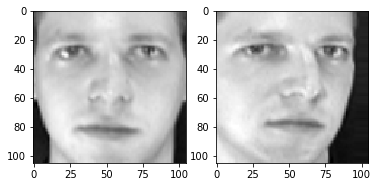

In [6]:
# Testing model on images of same person
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(olivetti_ds[0, 0, ...], cmap='gray')
axarr[1].imshow(olivetti_ds[0, 1, ...], cmap='gray')
img1 = np.reshape(olivetti_ds[0, 0, ...], (1, IMG_SIZE, IMG_SIZE, 1))
img2 = np.reshape(olivetti_ds[0, 1, ...], (1, IMG_SIZE, IMG_SIZE, 1))
print(s_net.test(img1, img2))

[[False]]


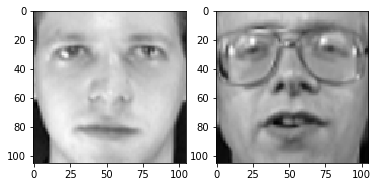

In [7]:
# Testing model on images of different people
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(olivetti_ds[0, 0, ...], cmap='gray')
axarr[1].imshow(olivetti_ds[1, 0, ...], cmap='gray')
img1 = np.reshape(olivetti_ds[0, 0, ...], (1, IMG_SIZE, IMG_SIZE, 1))
img2 = np.reshape(olivetti_ds[1, 0, ...], (1, IMG_SIZE, IMG_SIZE, 1))
print(s_net.test(img1, img2))

### Here's a plot of the validation and testing one-shot accuracies to the number of interations during training

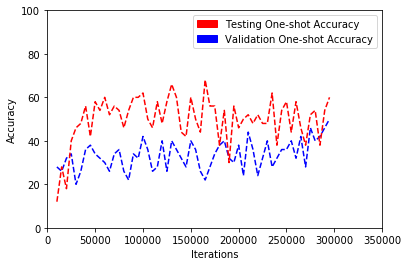

In [11]:
num_iterations = []
val_accs = []
test_accs = []
with open('log.txt', 'r') as ins:
    for line in ins:
        iterations, val_acc, test_acc = line.strip().split()
        num_iterations.append(int(iterations))
        val_accs.append(float(val_acc))
        test_accs.append(float(test_acc))

fig, ax = plt.subplots()
ax.plot(num_iterations, val_accs, 'b--', num_iterations, test_accs, 'r--')
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')

red_patch = mpatches.Patch(color='red', label='Testing One-shot Accuracy')
blue_patch = mpatches.Patch(color='blue', label='Validation One-shot Accuracy')
ax.legend(handles=[red_patch, blue_patch])

plt.axis([0, 350000, 0, 100])
plt.show()

## Conclusions and Future Work
1. Using these hyperparameters, the model was only to achieve a highest validation accuracy of 50% and testing accuracy of 68%.
2. Adopting layer wise learning rates/momentum as in the paper could further increase the performance.
3. Data augmentation should be done as well, including flipping, rotating and applying affine transformations.

## References
1. [Original paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
2. [https://sorenbouma.github.io/blog/oneshot/](https://sorenbouma.github.io/blog/oneshot/)
3. [https://github.com/sorenbouma/keras-oneshot](https://github.com/sorenbouma/keras-oneshot)
4. [https://github.com/Kadenze/siamese_net](https://github.com/Kadenze/siamese_net)
5. [the Olivetti faces dataset](http://scikit-learn.org/stable/datasets/olivetti_faces.html)
6. [LFW dataset](http://vis-www.cs.umass.edu/lfw/)
